# Prediksi Kecepatan Angin Maksimum di Tanjungpinang Tahun 2022 dengan ARIMA

Notebook ini dibuat untuk proyek akhir Pembelajaran Mesin. Topik dari proyek ini adalah memprediksi kecepatan angin maksimum di Tanjungpinang tahun 2022 dengan model ARIMA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import toeplitz, lstsq
from statsmodels.tsa.stattools import acf, pacf

## Fungsi Utilitas

In [2]:
def create_windowed_dataset(dataset, size):
    '''
    Membuat dataset yang terbagi berdasarkan ukuran jendela yang dibuat.
    Tiap item pada dataset yang terbagi berisi
    [a, b, c, ..., z] dengan:
    * a, b, c, ... sebagai data yang dilatih
    * z sebagai label

    Args:
        dataset (list/array): dataset yang akan dibuatkan jendelanya
        size (int): ukuran jendela
    
    Hasil:
        windowed_dataset (np list/array)
    '''
    windowed_dataset = []

    for index in range(0, len(dataset)):
        window = dataset[index:index + size]
        
        if len(window) < size:
            break

        windowed_dataset.append(window)

    return np.array(windowed_dataset)

In [3]:
def autocolleration_function(dataset, lag):
    '''
    Menghitung autokolerasi dari dataset dengan lag tertentu

    Args:
        dataset (list/array): dataset yang akan dihitung ACF
        lag (int): jeda antardata
    
    Hasil:
        1 (float) jika lag = 0
        r_lag (float) jika lag > 0
    '''
    y_mean = dataset.mean()
    T = len(dataset)
    
    c_0 = np.sum((dataset.to_numpy() - y_mean) ** 2) / T

    if lag == 0:
        return 1
    
    c_k = np.sum((dataset[:T - lag] - y_mean).to_numpy() * (dataset[lag:] - y_mean).to_numpy()) / T
    r_lag = c_k / c_0

    return r_lag

In [4]:
def partial_autocolleration_function(dataset, lag):
    '''
    Menghitung autokolerasi parsial (PACF) dari dataset dengan lag tertentu

    Args:
        dataset (list/array): dataset yang akan dihitung PACF
        lag (int): jeda antardata

    Hasil:
        p (float)
    '''
    p = 0

    if lag == 0:
        p = 1
        return p
    if lag == 1:
        p = autocolleration_function(dataset, lag)
        return p
    
    nilai_acf = np.array([autocolleration_function(dataset, k) for k in range(lag + 1)])
    matriks_acf = toeplitz(nilai_acf[:lag])
    nilai_pacf = np.linalg.inv(matriks_acf) @ nilai_acf[1:]

    p = nilai_pacf[-1]

    return p

In [39]:
# TODO: Lengkapi dan sempurnakan class ARIMA (capek coy)
class ARIMA:
    def __init__(self, dataset, paramaters):
        #self.dataset = dataset
        self.p, self.d, self.q = paramaters
        self.const = 0

        # Menyiapkan nilai sementara koofisien ARIMA
        self.ar_coef = np.array([partial_autocolleration_function(dataset, k) for k in range(1, self.p + 1)])
        self.ma_coef = np.array([autocolleration_function(dataset, k) for k in range(1, self.q + 1)])
    
    def predict(self, dataset):
        # TODO: Need to be done
        '''
            Fungsi memprediksi nilai berikutnya berdasarkan dataset yang disediakan.
        '''
        windowed_dataset = create_windowed_dataset(dataset, max(self.p, self.q) + 1)

        print('Dataset shape ', dataset.shape)

        #X = windowed_dataset[:, -self.p - 1:-1]
        #y = windowed_dataset[:, -1]
        X = dataset[:-1]
        y = dataset[-1]

        print('X shape ', X.shape)
        print('Y shape ', y.shape)
        print('AR coef shape ', self.ar_coef.shape)

        ar_result = X @ self.ar_coef[::-1] + self.const
        
        residuals = y - ar_result

        print('AR result shape ', ar_result.shape)
        print('Residuals shape ', residuals.shape)

        #windowed_residuals = create_windowed_dataset(residuals, self.q + 1)

        print('Windowed res shape ', windowed_residuals.shape)
        print('MA coef shape ', self.ma_coef.shape)

        #ma_result = windowed_residuals[:, -self.q - 1:-1] @ self.ma_coef[::-1]
        ma_result = windowed_residuals[:, -self.q - 1:-1] @ self.ma_coef[::-1]

        print('ar_result: ', ar_result.shape)
        print('residuals: ', residuals.shape)
        print('ma_result: ', ma_result.shape)

        result = ar_result + ma_result

        if self.d > 0:
            pass

        return result

    def fit(self, dataset, train_split=0.5):
        # NOTE: Pakai least square untuk men-fitkan paramater
        windowed_dataset = create_windowed_dataset(dataset, self.p + 1)
        train_size = int(len(dataset) * train_split)

        X_train = windowed_dataset[:train_size, :-1]
        X_test = windowed_dataset[train_size:, :-1]

        y_train = windowed_dataset[:train_size, -1]
        y_test = windowed_dataset[train_size:, -1]

        # Fit-kan koofisien AR pada data latih dengan least square
        X_ar_train = np.concatenate((X_train[:, :self.p], np.array([np.ones(len(X_train))]).T), axis=-1)
        self.ar_coef, _, _, _= lstsq(X_ar_train, y_train)
        self.ar_coef, self.const = self.ar_coef[:-1], self.ar_coef[-1]

        # Hitung hasil perkalian koofisien pada data test
        test_result = X_test[:, :self.p] @ self.ar_coef[::-1] + self.const

        # Hitung galat hasil perkalian tersebut dengan data sebenarnya
        residuals = y_test - test_result

        windowed_residuals = create_windowed_dataset(residuals, self.q + 1)
        X_residuals = windowed_residuals[:, :-1]
        y_residuals = windowed_residuals[:, -1]

        # Fit-kan koofisien MA pada galat tersebut dengan least square
        self.ma_coef, _, _, _= lstsq(X_residuals, y_residuals)

        #print(self.ar_coef)
        #print(self.ma_coef)

    def fit_wout_split(self, dataset):
        # NOTE: Experiment
        #       Pakai least square untuk men-fitkan paramater
        windowed_dataset = create_windowed_dataset(dataset, self.p + 1)

        X = windowed_dataset[:, :-1]
        y = windowed_dataset[:, -1]

        # Fit-kan koofisien AR pada data latih dengan least square
        X_ar_train = np.concatenate((X[:, :self.p], np.array([np.ones(len(X))]).T), axis=-1)
        self.ar_coef, _, _, _= lstsq(X_ar_train, y)
        self.ar_coef, self.const = self.ar_coef[:-1], self.ar_coef[-1]

        # Hitung hasil perkalian koofisien pada data test
        test_result = X[:, :self.p] @ self.ar_coef[::-1] + self.const

        # Hitung galat hasil perkalian tersebut dengan data sebenarnya
        residuals = y - test_result

        windowed_residuals = create_windowed_dataset(residuals, self.q + 1)
        X_residuals = windowed_residuals[:, :-1]
        y_residuals = windowed_residuals[:, -1]

        # Fit-kan koofisien MA pada galat tersebut dengan least square
        self.ma_coef, _, _, _= lstsq(X_residuals, y_residuals)

        print(self.ar_coef)
        print(self.ma_coef)
    
    def forecast(self, dataset):
        windowed_dataset = create_windowed_dataset(dataset, self.p + 1)

        X = windowed_dataset[-self.q:, :-1]
        y = windowed_dataset[-self.q:, -1]

        ar_result = X @ self.ar_coef[::-1] + self.const
        
        residuals = y - ar_result

        print('AR result shape ', ar_result.shape)
        print('Residuals shape ', residuals.shape)

        print('MA coef shape ', self.ma_coef.shape)

        #ma_result = windowed_residuals[:, -self.q - 1:-1] @ self.ma_coef[::-1]
        ma_result = residuals @ self.ma_coef[::-1]

        print('ar_result: ', ar_result.shape)
        print('residuals: ', residuals.shape)
        print('ma_result: ', ma_result.shape)

        result = ar_result[-1] + ma_result
        return result

In [40]:
arima = ARIMA(dummy_kec_angin, (2, 0, 3))
arima.fit_wout_split(dummy_kec_angin[:6])


[-0.38888889 -1.49382716]
[ 0.00512989  0.54248578 -0.95993052]


In [45]:
print(arima.forecast(dummy_kec_angin[:8]))

AR result shape  (3,)
Residuals shape  (3,)
MA coef shape  (3,)
ar_result:  (3,)
residuals:  (3,)
ma_result:  ()
33.1562382013264


In [ ]:
arima = ARIMA(data_dummy['kecepatan_angin'], (2, 0, 3))
arima.fit(data_dummy['kecepatan_angin'])
arima.predict(data_dummy['kecepatan_angin'])

In [ ]:
tes = create_windowed_dataset(data_dummy['kecepatan_angin'], 3)

In [ ]:
tes[:,:-1]

In [ ]:
np.concatenate((tes[:,:2], np.array([np.ones(len(tes))]).T), axis=-1)

## Pengertian ARIMA

## Pengujian Model dengan Data Dummy

In [9]:
# Membuat data dummy
data_dummy = pd.read_csv('./kecepatan_angin_dummy.csv')
data_dummy

,kecepatan_angin
0,7
1,8
2,14
3,5
4,14
5,3
6,12
7,8
8,5
9,9


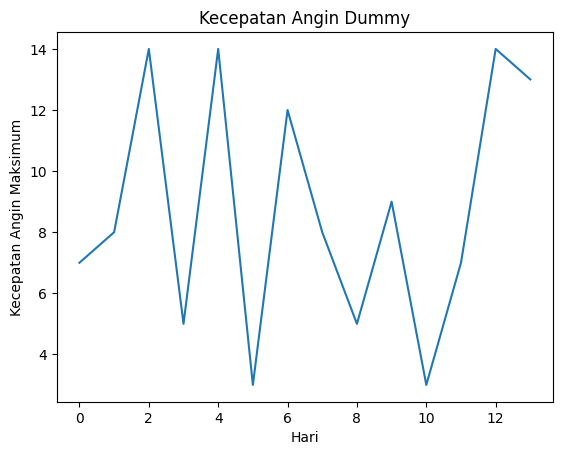

In [10]:
dummy_kec_angin = data_dummy['kecepatan_angin']

# Plot dataset dummy
fig, ax = plt.subplots()
plt.plot(dummy_kec_angin)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Dummy')

plt.show()

In [11]:
type(dummy_kec_angin) == np.ndarray

False

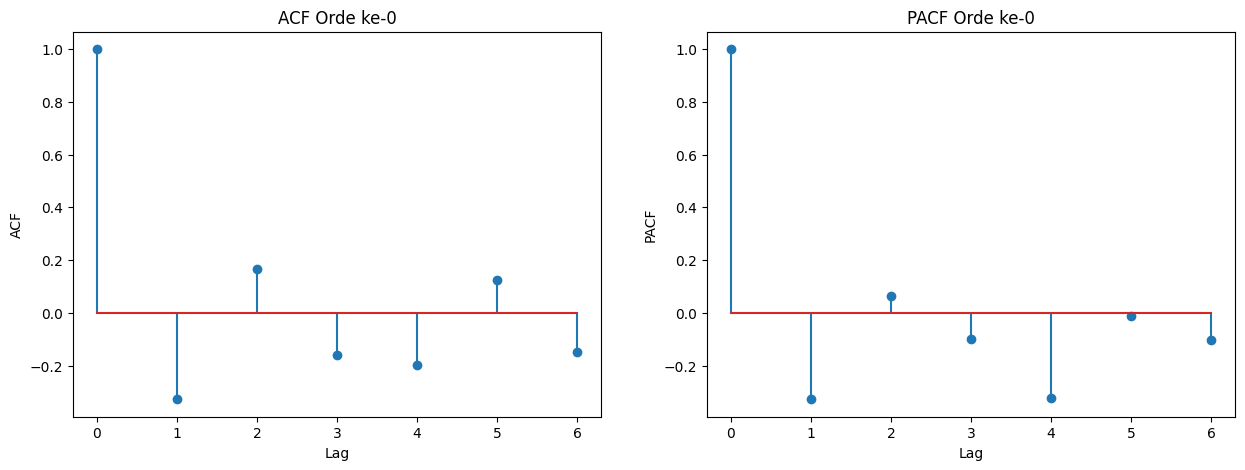

In [12]:
# Plot 6 nilai ACF pertama dari data dummy
acf_data_dummy = [autocolleration_function(dummy_kec_angin, k)
                    for k in range(7)]

# Plot 6 nilai PACF pertama dari data dummy
pacf_data_dummy = [partial_autocolleration_function(dummy_kec_angin, k)
                    for k in range(7)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].stem(acf_data_dummy)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
ax[0].set_title('ACF Orde ke-0')

ax[1].stem(pacf_data_dummy)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_title('PACF Orde ke-0')

plt.show()

## Membuka Dataset

In [13]:
# Buka dataset
df_kecepatan_angin = pd.read_csv('./kecepatan_angin_tpi_2022.csv',
                                 delimiter=';'
                                )
df_kecepatan_angin

,tanggal,kecepatan_maksimum
0,01/01/2022,4
1,02/01/2022,3
2,03/01/2022,3
3,04/01/2022,6
4,05/01/2022,7
...,...,...
361,28/12/2022,6
362,29/12/2022,8
363,30/12/2022,10
364,31/12/2022,13


In [14]:
df_kecepatan_angin['kecepatan_maksimum'].describe()

count    366.000000
mean       5.838798
std        1.854642
min        3.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       15.000000
Name: kecepatan_maksimum, dtype: float64

In [15]:
# Konversi tipe data kolom tanggal menjadi tipe data datetime
df_kecepatan_angin['tanggal'] = pd.to_datetime(df_kecepatan_angin['tanggal'], dayfirst=True)

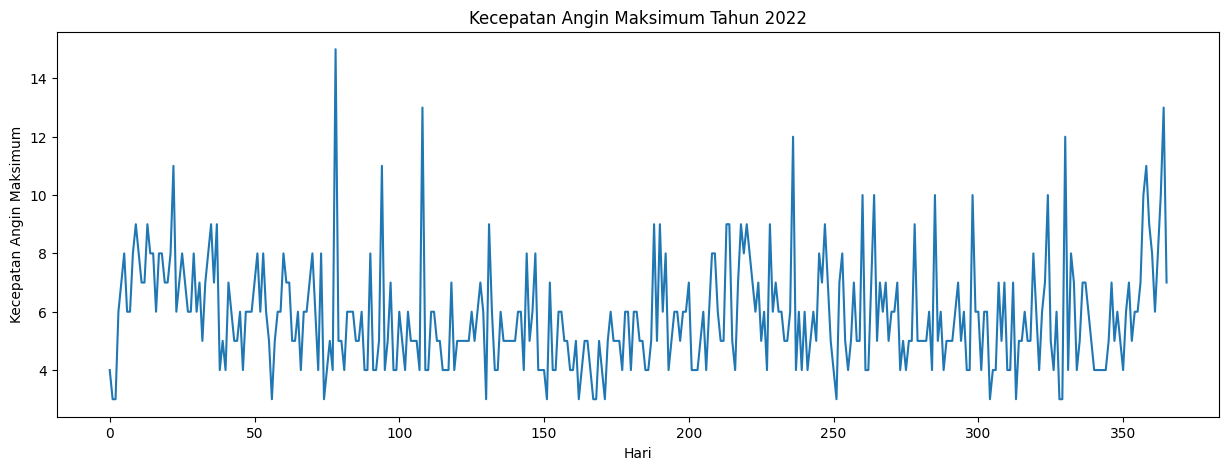

In [16]:
kecepatan_angin = df_kecepatan_angin['kecepatan_maksimum']

# Plot dataset
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(kecepatan_angin)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Maksimum Tahun 2022')

plt.show()

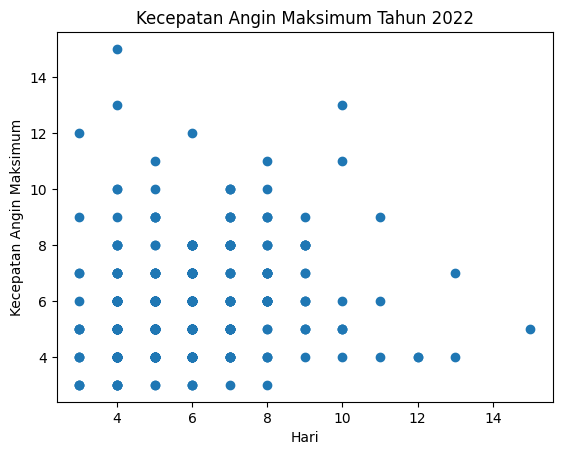

In [17]:
# Scatter dataset
scatter_kec_angin_per_hari = create_windowed_dataset(kecepatan_angin, 2)

fig, ax = plt.subplots()
plt.scatter(scatter_kec_angin_per_hari[:,0], scatter_kec_angin_per_hari[:,1])

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Maksimum Tahun 2022')

plt.show()

## Menentukan Paramater untuk ARIMA

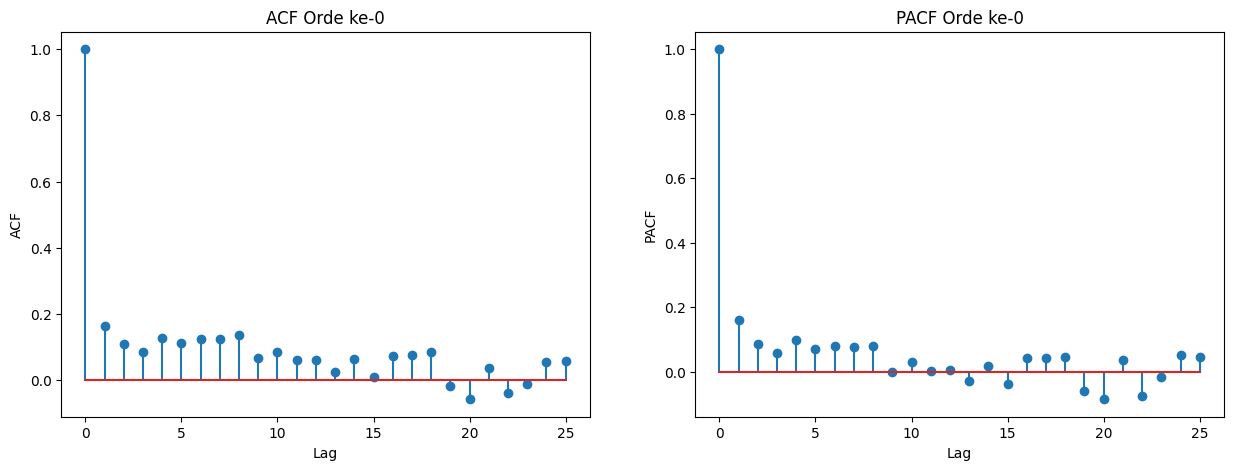

In [18]:
# Plot 25 nilai ACF pertama dari dataset
acf_kec_angin = [autocolleration_function(kecepatan_angin, k)
                    for k in range(26)]

# Plot 25 nilai PACF pertama dari dataset
pacf_kec_angin = [partial_autocolleration_function(kecepatan_angin, k)
                    for k in range(26)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].stem(acf_kec_angin)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
ax[0].set_title('ACF Orde ke-0')

ax[1].stem(pacf_kec_angin)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_title('PACF Orde ke-0')

plt.show()

Berdasarkan grafik tersebut, karena tidak ada menunjukkan pola apayah, maka data kecepatan angin maksimum perlu di-_differencing_ (menghitung selisih antardata).

In [19]:
print(kecepatan_angin)
print(kecepatan_angin.shift().fillna(method='bfill'))

0       4
1       3
2       3
3       6
4       7
       ..
361     6
362     8
363    10
364    13
365     7
Name: kecepatan_maksimum, Length: 366, dtype: int64
0       4.0
1       4.0
2       3.0
3       3.0
4       6.0
       ... 
361     8.0
362     6.0
363     8.0
364    10.0
365    13.0
Name: kecepatan_maksimum, Length: 366, dtype: float64


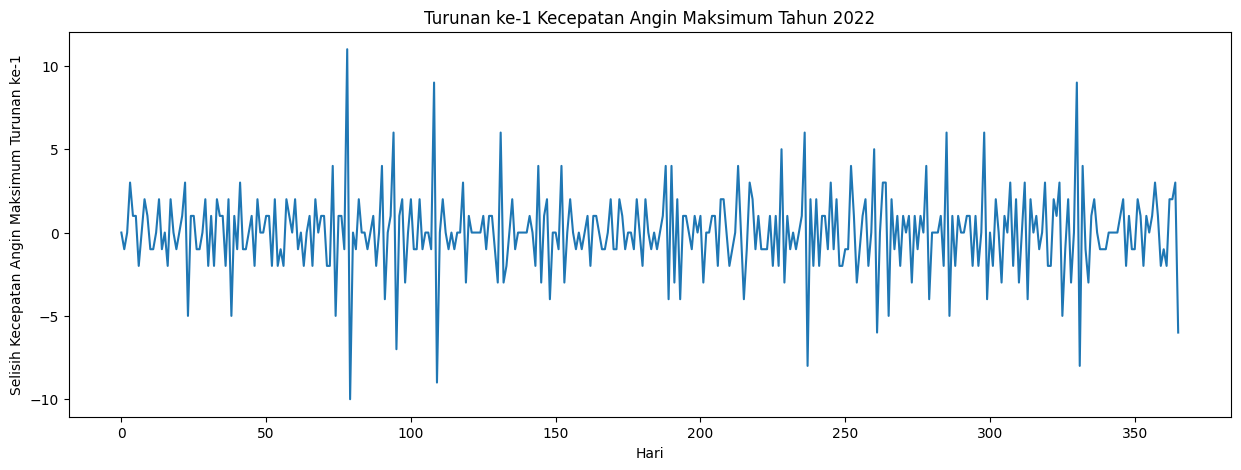

In [20]:
kecepatan_angin_orde_1 = kecepatan_angin - kecepatan_angin.shift().fillna(method='bfill')

# Plot dataset turunan ke-1
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(kecepatan_angin_orde_1)

ax.set_xlabel('Hari')
ax.set_ylabel('Selisih Kecepatan Angin Maksimum Turunan ke-1')
ax.set_title('Turunan ke-1 Kecepatan Angin Maksimum Tahun 2022')

plt.show()

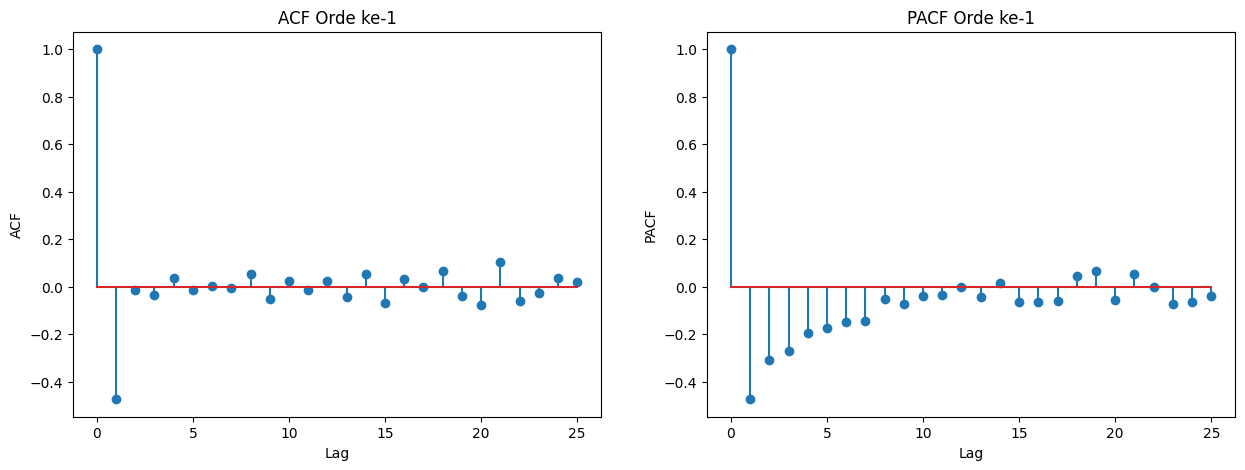

In [21]:
# Plot 25 nilai ACF pertama dari dataset
acf_kec_angin = [autocolleration_function(kecepatan_angin_orde_1, k)
                    for k in range(26)]

# Plot 25 nilai PACF pertama dari dataset
pacf_kec_angin = [partial_autocolleration_function(kecepatan_angin_orde_1, k)
                    for k in range(26)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].stem(acf_kec_angin)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
ax[0].set_title('ACF Orde ke-1')

ax[1].stem(pacf_kec_angin)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_title('PACF Orde ke-1')

plt.show()

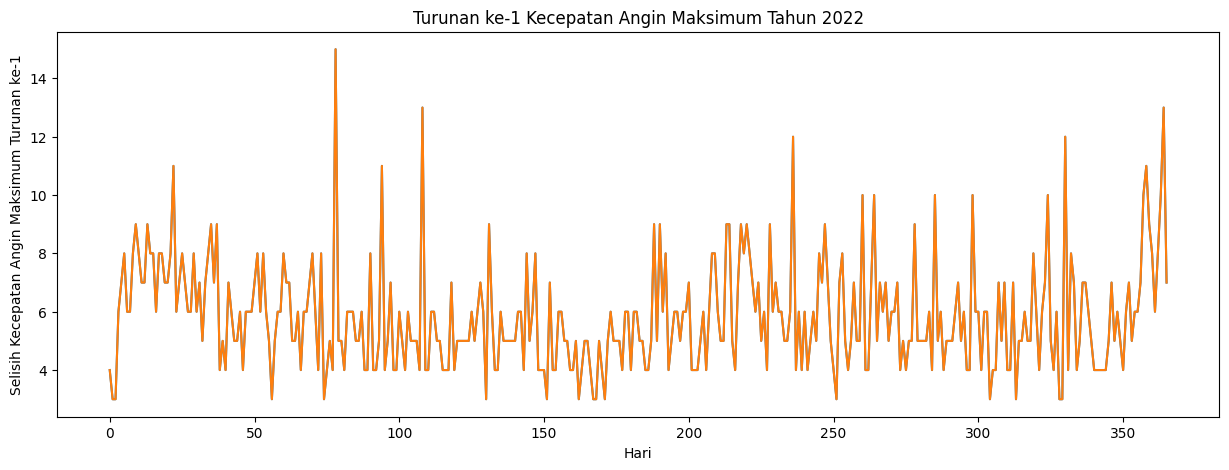

In [22]:
forecast = []
    
### START CODE HERE  
for time in range(len(kecepatan_angin) - 30):
    forecast.append(kecepatan_angin[time:time + 30].mean())
    
# Conver to a numpy array
np_forecast = np.array(forecast)

# Plot dataset turunan ke-1
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(np.array(kecepatan_angin))
plt.plot(kecepatan_angin_orde_1 + kecepatan_angin.shift().fillna(method='backfill'))

ax.set_xlabel('Hari')
ax.set_ylabel('Selisih Kecepatan Angin Maksimum Turunan ke-1')
ax.set_title('Turunan ke-1 Kecepatan Angin Maksimum Tahun 2022')

plt.show()

## Membagi Data

## Melatih Data

## Menvalidasi Data